In [1]:
"""
This module implements the Lowess function for nonparametric regression.
Functions:
lowess Fit a smooth nonparametric regression curve to a scatterplot.
For more information, see
William S. Cleveland: "Robust locally weighted regression and smoothing
scatterplots", Journal of the American Statistical Association, December 1979,
volume 74, number 368, pp. 829-836.
William S. Cleveland and Susan J. Devlin: "Locally weighted regression: An
approach to regression analysis by local fitting", Journal of the American
Statistical Association, September 1988, volume 83, number 403, pp. 596-610.
"""

# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#
# License: BSD (3-clause)

from math import ceil
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg


def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
#             beta = linalg.solve(A, b)
            beta = linalg.lstsq(A, b)[0]
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

# if __name__ == '__main__':
#     import math
#     n = 100
#     x = np.linspace(0, 2 * math.pi, n)
#     y = np.sin(x) + 0.3 * np.random.randn(n)

#     f = 0.25
#     yest = lowess(x, y, f=f, iter=3)

#     import pylab as pl
#     pl.clf()
#     pl.plot(x, y, label='y noisy')
#     pl.plot(x, yest, label='y pred')
#     pl.legend()
#     pl.show()

In [2]:
%matplotlib inline

import pickle
import matplotlib.pyplot as plt
import numpy as np
import ipdb
import copy
import seaborn as sns
# plt.rcParams['figure.dpi'] = 150

In [3]:
p2saved_file = '/data/jianhao/hepatocyte_update_dataset_101619/new_results_with_monoc_NF_100'
num_target_genes = 1000
num_TFs = 200

with open(p2saved_file, 'rb') as f:
    results_all = pickle.load(f)
    
# results_all.keys()

In [4]:
weight_dic = results_all['weight_dic']
TF_ids = results_all['TF_ids']
target_ids = results_all['query_targets']
# print('length of TF: ',len(TF_ids))

for label in weight_dic:
#     print(weight_dic[label].shape)
    break

In [5]:
# results_all['weight_dic'].keys()

# TF importance in each state

In [6]:
import scipy.stats as st
def find_significant_TF_per_target(weight_vec, th = 0.9):
    z_scores = st.zscore(weight_vec)
    cdfs = st.norm.cdf(z_scores)
    outside_90_intervals = np.logical_or(cdfs > th, cdfs < 1 - th)
    inside_90_intervals = np.logical_and(cdfs <= th, cdfs >= 1 - th)
    significant_weights_indicator = outside_90_intervals
    return significant_weights_indicator

In [8]:
a = np.array([[1, 2, 3], [4, 5, 6], [4, 5, 6]])
b = st.zscore(a, axis = 0)
c = st.zscore(a, axis = 1)
# print(b)
# print(c)
cdfs = st.norm.cdf(b)
# print(cdfs)

In [9]:
def array_to_rank(in_arr):
    '''
    The bigger the element, the higher rank (larger number in ranks list)
    '''
    ### Rank with tie being broke arbitrarily
#     np_arr = np.array(in_arr)
#     tmp = (np_arr).argsort()
#     ranks = np.empty_like(tmp)
#     ranks[tmp] = np.arange(len(np_arr))
    ### Rank with tie being the same.
    num_map  = {j: i for i, j in enumerate(sorted(set(in_arr)))}
    w_test_col_rank = [num_map[x] for x in in_arr]
    ranks = np.array(w_test_col_rank)
    return ranks

def sort_TF_by_ranking(weight_dic, TF_ids, top_k = 5):
    '''
    weight_dic: {label: weight_mat}
    weight_mat: num_TF * num_target
    '''
    len_of_TF = len(TF_ids)
    weight_dic_new = copy.deepcopy(weight_dic)
    for label in weight_dic_new:
        weight_mat = weight_dic_new[label]
#         weight_mat = np.abs(st.zscore(weight_mat, axis = 0))
        for col_idx in range(weight_mat.shape[1]):
            w_vector = weight_mat[:len_of_TF, col_idx]
            sig_TF = find_significant_TF_per_target(w_vector)
            w_vector *= sig_TF
            ranks = array_to_rank(abs(w_vector))
            weight_dic_new[label][:len_of_TF, col_idx] = ranks
    
    # drop the bias term in weight_mat.
    for label in weight_dic_new:
        weight_mat = weight_dic_new[label]
        weight_dic_new[label] = weight_mat[:len_of_TF, :]
    
    # sort TFs based on their average ranking
    TF_importance = {}
#     fig = plt.figure(figsize = [6, 6], dpi = 150)
    for label in weight_dic_new:
        
        average_importance = weight_dic_new[label].mean(axis = 1)
        selected_idx = []

        order_of_avg_importance = average_importance.argsort()
        top_k_avg_importance = np.zeros_like(average_importance)
        top_k_avg_idx = order_of_avg_importance[-top_k:]
        top_k_avg_importance[top_k_avg_idx] = average_importance[top_k_avg_idx]
        
        for idx, val in enumerate(top_k_avg_importance):
            if val > 0:
                selected_idx.append(idx)
        topk_TF = [TF_ids[x] for x in selected_idx]
        
        
#         ax = fig.add_subplot(1, len(weight_dic_new), label)
#         max_rank = np.max(np.max(weight_dic_new[label]))
# #         im = ax.imshow(weight_dic_new[label] > max_rank - top_k)
#         ax = sns.heatmap(weight_dic_new[label] > max(0, max_rank - top_k), 
#                          cmap = ['grey', 'r'], 
#                          cbar = False)
#         ax.set_xlabel('target index', fontsize = 5)
# #         ax.set_xticks(None)
# #         ax.xaxis.set_ticks_position('none') 
# #         ax.xaxis.set_ticks('none')
#         ax.tick_params(axis='x', which='both', length=0, labelbottom=False)
# #         ax.set_ylabel('TF ids')
#         if label == 1:
#             ax.set_yticks(selected_idx)
#             ax.set_yticklabels(topk_TF, fontsize = 5)
#         else:
#             ax.tick_params(axis = 'both', which = 'both', length = 0, labelleft = False)
#         ax.set_title('cluster label {}'.format(label), fontsize = 5)
        
        
        rank_TF = array_to_rank(average_importance)
        TF_importance[label] = {}
        TF_importance[label]['TF_average_importance'] = average_importance
        TF_importance[label]['TF_ranking'] = rank_TF
        TF_importance[label]['top k TFs'] = topk_TF
#     plt.show()
    return TF_importance, weight_dic_new


In [10]:
test_arr = [5, 2, 4, 2, 1]
test_rank = array_to_rank(test_arr)
# print(test_rank)

In [11]:
TF_ranking, weight_dic_ranking = sort_TF_by_ranking(weight_dic, TF_ids, 5)
# print(weight_dic_ranking)

In [21]:
for label in weight_dic_ranking:
    rank_mtx = weight_dic_ranking[label]
    max_rank = rank_mtx.max()
    mean_rank = rank_mtx.mean()
    print('state: {}\t max importance: {}\t'.format(label, max_rank, mean_rank))

state: 1	 max importance: 10.0	
state: 2	 max importance: 16.0	
state: 3	 max importance: 10.0	
state: 4	 max importance: 16.0	
state: 5	 max importance: 12.0	
state: 6	 max importance: 11.0	
state: 7	 max importance: 14.0	
state: 8	 max importance: 12.0	
state: 9	 max importance: 12.0	


In [17]:
list_of_important_TF = []
for label in TF_ranking:
    print('Top 5 driver genes of states', label, ':')
    print(TF_ranking[label]['top k TFs'])
    for tf in TF_ranking[label]['top k TFs']:
        list_of_important_TF.append(tf)

Top 5 driver genes of states 1 :
['CEBPB', 'ATF5', 'CREB3L3', 'TSC22D1', 'PPARA']
Top 5 driver genes of states 2 :
['CEBPB', 'YBX1', 'ID3', 'ATF5', 'ZBTB20']
Top 5 driver genes of states 3 :
['CEBPB', 'YBX1', 'CREB3L3', 'ID2', 'ZBTB20']
Top 5 driver genes of states 4 :
['CEBPB', 'CEBPA', 'ATF5', 'CREB3L3', 'ZBTB20']
Top 5 driver genes of states 5 :
['CEBPB', 'YBX1', 'ATF5', 'CREB3L3', 'XBP1']
Top 5 driver genes of states 6 :
['CEBPB', 'YBX1', 'CEBPA', 'XBP1', 'ZBTB20']
Top 5 driver genes of states 7 :
['CEBPB', 'YBX1', 'JUND', 'XBP1', 'ZBTB20']
Top 5 driver genes of states 8 :
['CEBPB', 'YBX1', 'CEBPA', 'XBP1', 'PHF5A']
Top 5 driver genes of states 9 :
['NR1I3', 'CEBPB', 'YBX1', 'CEBPA', 'ZBTB20']


In [24]:
union_of_TFs = set(list_of_important_TF)
print('Union of all top 5 driver genes:')
print(union_of_TFs)
index_of_union_TF = [TF_ids.index(tf) for tf in union_of_TFs]
# print(index_of_union_TF)
# print('- ' * 7) 
# print([TF_ids[x] for x in index_of_union_TF])
# print(len(union_of_TFs))

Union of all top 5 driver genes:
{'ZBTB20', 'ID2', 'TSC22D1', 'ATF5', 'PHF5A', 'CEBPB', 'CEBPA', 'XBP1', 'CREB3L3', 'YBX1', 'JUND', 'ID3', 'NR1I3', 'PPARA'}


In [26]:
# index_of_NCOR1 = TF_ids.index('NCOR1')
# TF_ids[index_of_NCOR1]
# for label in weight_dic_ranking:
#     weight_mtx = weight_dic_ranking[label]
#     ncor1_row = weight_mtx[index_of_NCOR1, :]
#     print(label, '\t', max(ncor1_row),'\t', np.count_nonzero(ncor1_row),'\t', np.mean(ncor1_row))

In [28]:
print('{}\t{}\t{}\t{}\t{}'.format('state', 'mean(avg IM)', 'max(avg IM)', 'max(weight_mtx)', 'non-zero'))
for label in weight_dic_ranking:
    weight_mtx = weight_dic_ranking[label]
    row_average = np.mean(weight_mtx, axis = 1)
    
    print('{}\t{:.4f}\t\t{:.4f}\t\t{}\t\t{}'.format(label, np.mean(row_average), 
                                            max(row_average), np.max(weight_mtx),
                                             np.count_nonzero(weight_mtx)))

state	mean(avg IM)	max(avg IM)	max(weight_mtx)	non-zero
1	0.0385		1.6470		10.0		3187
2	0.0901		1.6250		16.0		5164
3	0.0817		1.6880		10.0		4973
4	0.1889		3.5240		16.0		7819
5	0.0673		1.9780		12.0		4475
6	0.0724		2.0770		11.0		4660
7	0.1527		2.6870		14.0		7043
8	0.0922		3.0200		12.0		5348
9	0.0784		1.8050		12.0		4875


In [30]:
largest_col = np.argmax(np.mean(weight_dic_ranking[4], axis = 0))
tmp_col = weight_dic_ranking[4][:, largest_col]
# print(np.count_nonzero(tmp_col))
# print(max(tmp_col))

In [31]:
def redraw_importance_matrices(weight_dic_new, TF_ids, selected_TF_set):    
    selected_idx = []
    topk_TF = []
    for idx, val in enumerate(TF_ids):
        if val in selected_TF_set:
            selected_idx.append(idx)
            topk_TF.append(val)
    
    fig = plt.figure(figsize = [6, 6], dpi = 150)
    for label in weight_dic_new:
        ax = fig.add_subplot(1, len(weight_dic_new), label)
        max_rank = np.max(np.max(weight_dic_new[label]))
#         im = ax.imshow(weight_dic_new[label] > max_rank - top_k)
        ax = sns.heatmap(weight_dic_new[label] > 0, 
                         cmap = ['grey', 'r'], 
                         cbar = False)
        ax.set_xlabel('target index', fontsize = 5)
#         ax.set_xticks(None)
#         ax.xaxis.set_ticks_position('none') 
#         ax.xaxis.set_ticks('none')
        ax.tick_params(axis='x', which='both', length=0, labelbottom=False)
#         ax.set_ylabel('TF ids')
        if label == 1:
            ax.set_yticks(selected_idx)
            ax.set_yticklabels(topk_TF, fontsize = 5)
        else:
            ax.tick_params(axis = 'both', which = 'both', length = 0, labelleft = False)
        ax.set_title('cluster label {}'.format(label), fontsize = 5)

    plt.show()

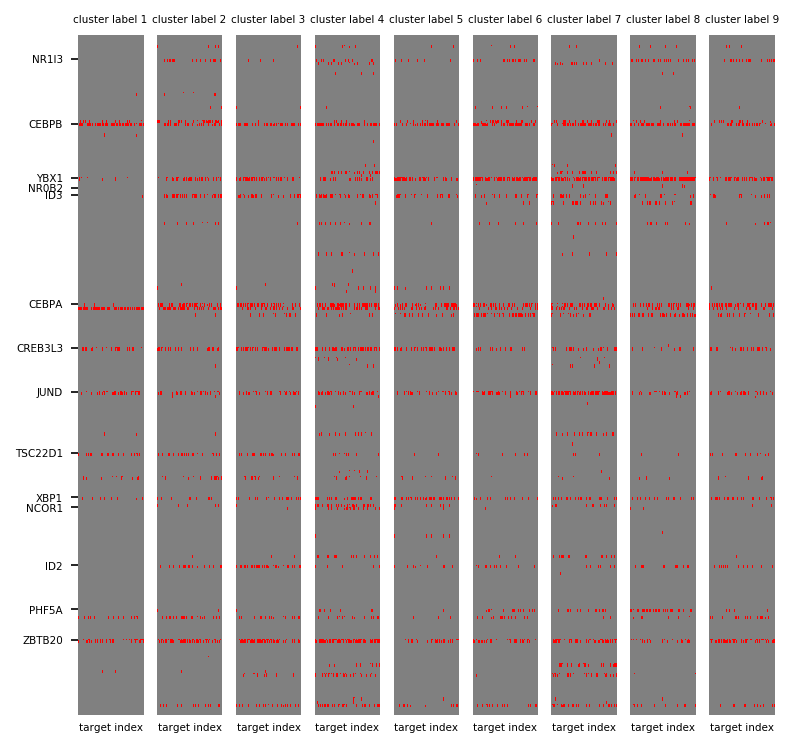

In [32]:
redraw_importance_matrices(weight_dic_ranking, TF_ids, 
                           ['CEBPA', 'NR1I3', 'ZBTB20', 'YBX1', 'ID3', 'ID2', 'PHF5A', 
                            'JUND', 'TSC22D1', #'ATF5', 
                            'XBP1', 'CEBPB', 'CREB3L3', 
#                             'PPARA', 
                            'NCOR1', 'NR0B2']
#                            {'YBX1', 'CEBPA', 'CEBPB', 'JUND', 'ID3', 'NCOR1',
#                                                        'TSC22D1', 'PHF5A'}
                          )

In [ ]:
# TF_ranking.keys()

In [ ]:
# TF_ranking[1].keys()

In [ ]:
# print(TF_ranking[1]['top k TFs'])
# print(TF_ranking[1]['TF_average_importance'])
# print(TF_ranking[1]['TF_ranking'])

#  Importance dynamics matrix

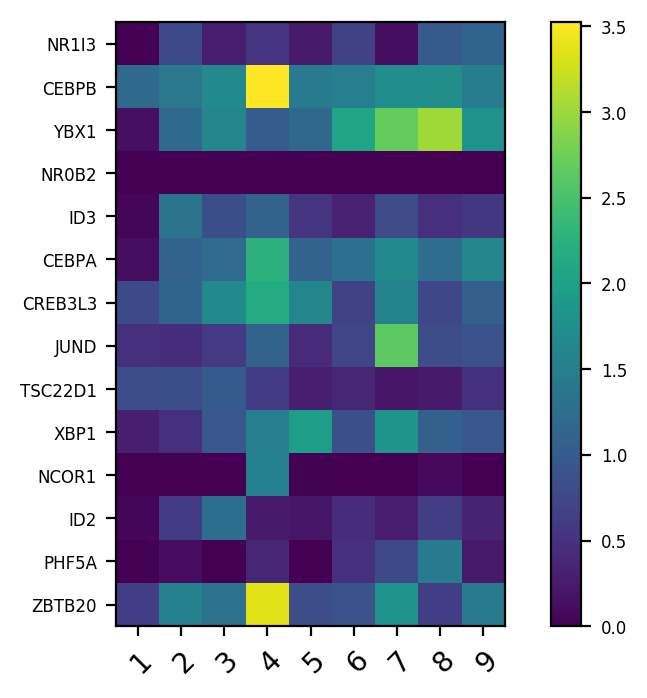

In [33]:
# set_of_TFs ={'YBX1', 'CEBPA', 'CEBPB', 'JUND', 'ID3', 'NCOR1',
#                                                        'TSC22D1', 'PHF5A'}
set_of_TFs = ['CEBPA', 'NR1I3', 'ZBTB20', 'YBX1', 'ID3', 'ID2', 'PHF5A', 
                            'JUND', 'TSC22D1', #'ATF5', 
                            'XBP1', 'CEBPB', 'CREB3L3', 
#                             'PPARA', 
                            'NCOR1', 'NR0B2']
index_of_union_TF = [idx for idx, val in enumerate(TF_ids) if val in set_of_TFs]

change_of_ranking_mat = np.empty((len(index_of_union_TF), len(TF_ranking)))
for label in TF_ranking:
    tmp = TF_ranking[label]['TF_average_importance']
    union_TF = tmp[index_of_union_TF]
    change_of_ranking_mat[:, label - 1] = union_TF

fig, ax = plt.subplots(dpi = 200)
tmp = ax.imshow(change_of_ranking_mat)
cb = plt.colorbar(tmp)
cb.ax.tick_params(labelsize=6) 
ax.set_yticks(range(len(index_of_union_TF)))
ax.set_yticklabels([TF_ids[x] for x in index_of_union_TF], fontsize = 6)
ax.set_xticks(range(len(TF_ranking)))
ax.set_xticklabels(x + 1 for x in range(len(TF_ranking)))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

/home/jianhao2/miniconda3/envs/conda3_py/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
/home/jianhao2/miniconda3/envs/conda3_py/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


NR0B2
[0.    0.    0.    0.    0.    0.    0.004 0.01  0.   ]


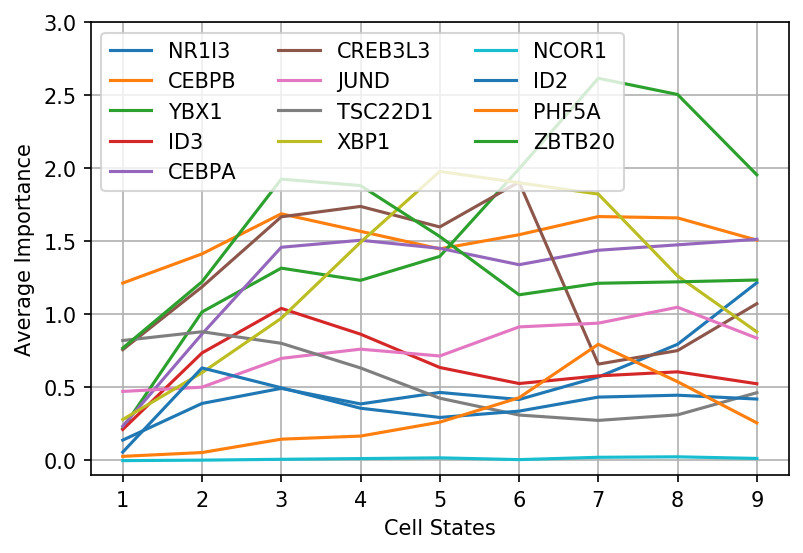

In [36]:
x = np.arange(1, (len(weight_dic_ranking))+1)
y_var = change_of_ranking_mat.var(axis = 1)
y_var_threshold = np.quantile(y_var, q = 0.4)
# y_var_threshold = 0
# print(len(y_var))
# line_style = iter([':', ':', ':', '-', '-', '-', '--', '--', '--', ])
# marker_style = iter(['.', '+', 'x','.', '+', 'x','.', '+', 'x',])
plt.rcParams['figure.dpi'] = 150
for idx, row in enumerate(change_of_ranking_mat):
    f = 0.25
    if row.var() >= y_var_threshold or True:
        try:
            yest = lowess(x, row, f=f, iter=3)
            plt.plot(x, yest, label = TF_ids[index_of_union_TF[idx]],
#                     marker = next(marker_style), linestyle = next(line_style)
                    )
        except:
            print(TF_ids[index_of_union_TF[idx]])
            print(row)
            continue

plt.legend(ncol = 3)
# fig=plt.figure(dpi = 500)
plt.grid()
plt.ylim(-0.1, 3)
plt.xlabel('Cell States')
plt.ylabel('Average Importance')
plt.show()